In [0]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold
import warnings
from six.moves import urllib
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use('seaborn')
from scipy.stats import norm, skew

In [0]:
#Load the Data
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
features = [c for c in train.columns if c not in ['ID_code', 'target']]

In [30]:
#Check for Missing Values after Concatination

obs = train.isnull().sum().sort_values(ascending = False)
percent = round(train.isnull().sum().sort_values(ascending = False)/len(train)*100, 2)
pd.concat([obs, percent], axis = 1,keys= ['Number of Observations', 'Percent'])

,Number of Observations,Percent
var_199,0,0.0
var_61,0,0.0
var_71,0,0.0
var_70,0,0.0
var_69,0,0.0
var_68,0,0.0
var_67,0,0.0
var_66,0,0.0
var_65,0,0.0
var_64,0,0.0


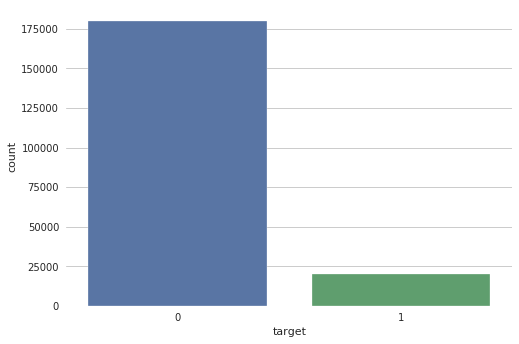

In [31]:
target = train['target']
train = train.drop(["ID_code", "target"], axis=1)
sns.set_style('whitegrid')
sns.countplot(target)

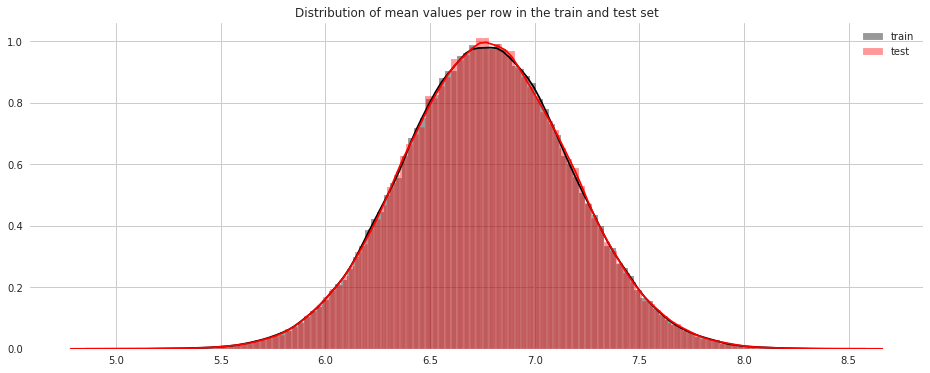

In [32]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train[features].mean(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test[features].mean(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend()
plt.show()

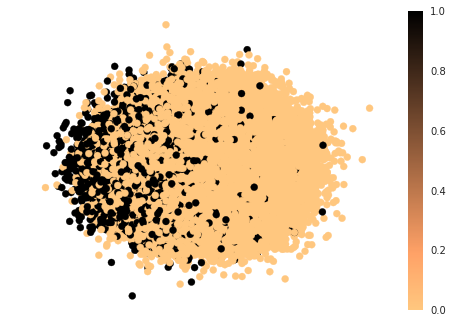

In [33]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)         
PCA_train_x = PCA(2).fit_transform(train_scaled)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="copper_r")
plt.axis('off')
plt.colorbar()
plt.show()

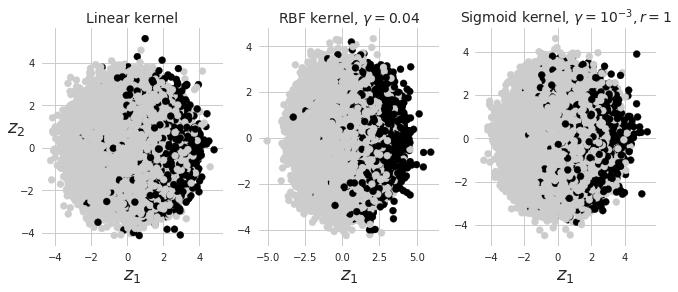

In [34]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    PCA_train_x = PCA(2).fit_transform(train_scaled)
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=target, cmap="nipy_spectral_r")
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [0]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [36]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.335,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.041,
    'learning_rate': 0.0083,
    'max_depth': -1,
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': -1
}
train.shape

(200000, 200)

In [38]:
num_folds = 7
features = [c for c in train.columns if c not in ['ID_code', 'target']]

folds = KFold(n_splits=num_folds, random_state=2319)
oof = np.zeros(len(train))
getVal = np.zeros(len(train))
predictions = np.zeros(len(target))
feature_importance_df = pd.DataFrame()

print('Light GBM Model')
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    
    X_train, y_train = train.iloc[trn_idx][features], target.iloc[trn_idx]
    X_valid, y_valid = train.iloc[val_idx][features], target.iloc[val_idx]
    
    X_tr, y_tr = augment(X_train.values, y_train.values)
    X_tr = pd.DataFrame(X_tr)
    
    print("Fold idx:{}".format(fold_ + 1))
    trn_data = lgb.Dataset(X_tr, label=y_tr)
    val_data = lgb.Dataset(X_valid, label=y_valid)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])
    
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    getVal[val_idx]+= clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Light GBM Model
Fold idx:1
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.91291	valid_1's auc: 0.894998
[10000]	training's auc: 0.923023	valid_1's auc: 0.898747
[15000]	training's auc: 0.930896	valid_1's auc: 0.899334
Early stopping, best iteration is:
[14340]	training's auc: 0.929889	valid_1's auc: 0.899439
Fold idx:2
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912948	valid_1's auc: 0.894931
[10000]	training's auc: 0.923189	valid_1's auc: 0.898289
[15000]	training's auc: 0.931076	valid_1's auc: 0.898369
Early stopping, best iteration is:
[12560]	training's auc: 0.927334	valid_1's auc: 0.898527
Fold idx:3
Training until validation scores don't improve for 4000 rounds.
[5000]	training's auc: 0.912681	valid_1's auc: 0.897624
[10000]	training's auc: 0.9229	valid_1's auc: 0.900903
[15000]	training's auc: 0.930777	valid_1's auc: 0.901217
Early stopping, best iteration is:
[13332]	training's auc: 0.928256	

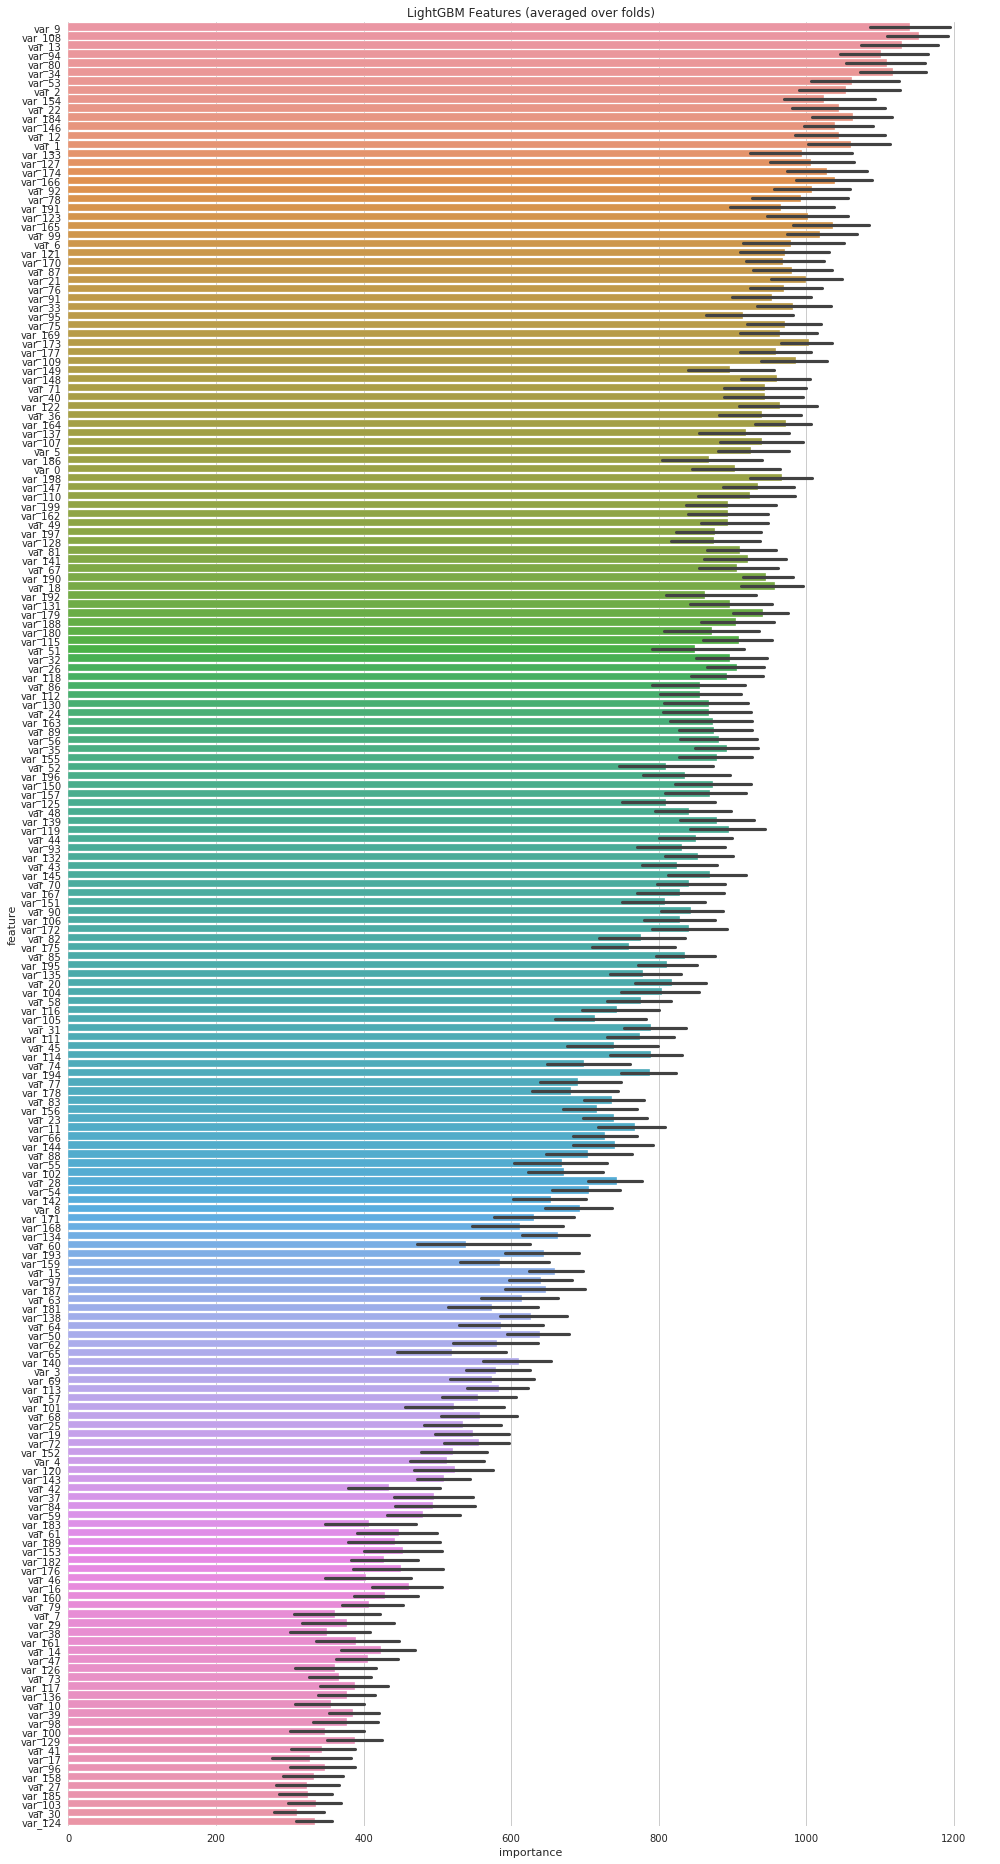

In [39]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [40]:
num_sub = 26
print('Saving the Submission File')
sub = pd.DataFrame({"ID_code": test.ID_code.values})
sub["target"] = predictions
sub.to_csv('submission{}.csv'.format(num_sub), index=False)
getValue = pd.DataFrame(getVal)
getValue.to_csv("Validation_kfold.csv")

Saving the Submission File
